# 🛍️ Análise de Vendas - SuperStore
## Introdução
Este notebook simula a análise de dados de uma loja virtual que deseja entender melhor seu desempenho em vendas para melhorar suas campanhas de marketing e reposição de estoque, o projeto tem como foco a formulação de perguntas orientadas por dados e limpeza de dados.

## Objetivo

O objetivo desta análise é obter insights que auxiliem as áreas de **marketing, logística e gestão de estoque** da loja.
As perguntas orientadas por dados incluem:

1. "Qual é a categoria mais vendida em cada região?"
2. "Em qual mês ocorrem mais vendas?"
3. "Qual é o intervalo médio entre a data de venda e a data de envio?"
4. "Qual produto é mais comprado em cada segmento de clientes?"

Tais perguntas são válidas pois tem como foco o negócio.

## Carregamento e inspeção dos dados

O conjunto de dados utilizado nesta análise é oriundo do Kaggle, e pode ser consultado pelo link: [Superstore Sales Dataset](https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting?resource=download). 

Inicialmente, o dataset foi importado para o Google Sheets, onde foram aplicadas algumas melhorias visuais com o objetivo de facilitar a leitura e análise dos dados, tais como:

- Adição de bordas em toda a tabela;
- Aplicação de cores alternadas entre as linhas;
- Formatação e congelamento do cabeçalho da planilha.

Abaixo, segue uma captura de tela da planilha já organizada — tal visualização é apenas uma parte do dataset. 

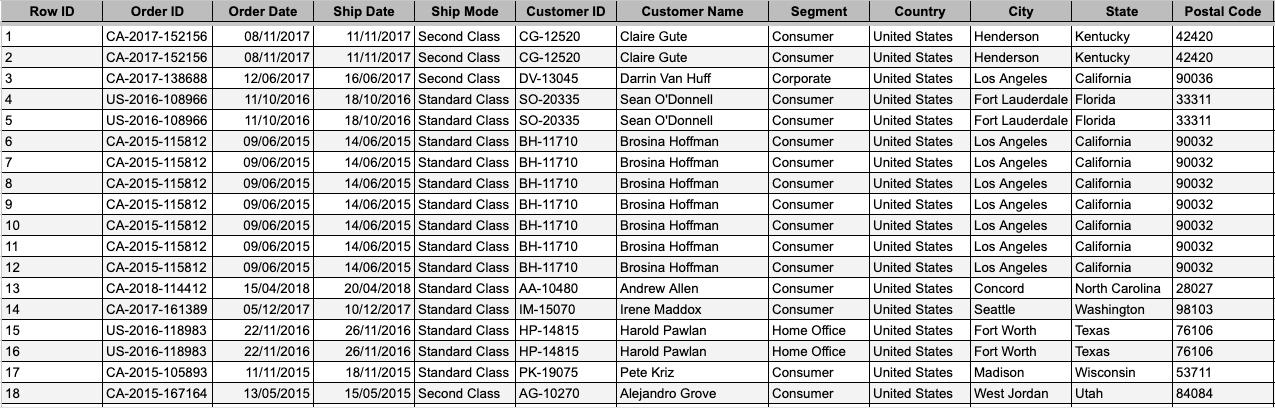

## Limpeza dos dados

A limpeza inicial dos dados foi realizada no Google Sheets, com foco em melhorar a qualidade da base antes da análise. As etapas aplicadas incluíram:

- Remoção de linhas duplicadas;
- Padronização de nomes de categorias e regiões;
- Correção de valores inconsistentes;
- Conversão de colunas para os tipos adequados (ex: datas como formato de data);
- Exclusão de registros com valores ausentes em colunas-chave.

Após a limpeza, a planilha foi exportada como .csv e carregada no ambiente SQL para realização das análises.

## Criação de novas colunas e análises iniciais

Para responder as perguntas citadas anteriormente, tornou-se necessário criar algumas colunas para auxiliar a análise:

1. Extração do mês na data de venda (para a pergunta número **2**);
2. Diferença entre a data de venda e data de envio (para a pergunta número **3**).

Utilizando o BigQuery, foram adicionadas as duas colunas, através dos seguintes comandos:

In [ ]:
-- adicionando a coluna do mês da venda
ALTER TABLE `neon-trilogy-461520-m7.SuperstoreSales_dataset.sales_data`
ADD COLUMN month_sale INT64;

-- alterando os valores da coluna, extraindo o mês da data da venda
UPDATE `neon-trilogy-461520-m7.SuperstoreSales_dataset.sales_data`
SET month_sale = EXTRACT(MONTH FROM order_date)
WHERE order_Date IS NOT NULL;

In [ ]:
-- adicionando a coluna de intervalo entre a venda e o envio
ALTER TABLE `neon-trilogy-461520-m7.SuperstoreSales_dataset.sales_data`
ADD COLUMN range_days INTEGER;

-- alterando os valores da coluna, fazendo a diferença entre a data do envio e da venda
ALTER TABLE `neon-trilogy-461520-m7.SuperstoreSales_dataset.sales_data`
SET range_days = DATE_DIFF(Ship_Date, Order_Date, DAY)
WHERE Ship_Date IS NOT NULL AND Order_Date IS NOT NULL;

Dessa forma, foi possível criar duas colunas que irão auxiliar a responder as perguntas 2 e 3.

## Respostas às perguntas

A seguir, foi feita a análise em si do conjunto de dados para responder as perguntas, as quais serão respondidas em ordem.

### 1. "Qual é a categoria mais vendida em cada região?"

Para responder a essa pergunta, foi necessário executar a consulta abaixo:

In [ ]:
SELECT 
  Region,
  Category,
  COUNT(*) AS total_vendas
FROM 
    `neon-trilogy-461520-m7.SuperstoreSales_dataset.sales_data`
GROUP BY 
    Region, 
    Category
ORDER BY 
    Region, 
    total_vendas DESC

Tal consulta seleciona as colunas de região do cliente, categoria do produto e contagem das categoria por região. A saída é ordenada da maior venda de categoria a cada região. 

Dessa forma, o resultado obtido foi:

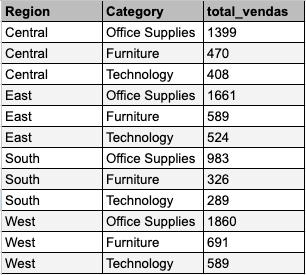

Dessa forma, pode-se observar que em todas as regiões a categoria que mais foi vendida foi a **Office Supplies**. Dessa forma, uma das recomendações para o marketing seria focar as campanhas neste ramo, e para o setor de estoque seria garantir que produtos desta categoria estejam disponíveis para a venda.

### 2. "Em qual mês ocorrem mais vendas?"

Para responder à pergunta sobre em que mês ocorrem mais vendas, é importante compreender a estrutura do conjunto de dados.

Cada linha do dataset representa um item vendido dentro de uma venda (ou seja, um produto dentro de um pedido). Isso significa que uma única venda (Order_ID) pode conter várias linhas — uma para cada produto comprado.

Dessa forma, ao utilizar a função SUM(sales), estaríamos calculando o valor financeiro total das vendas por mês. No entanto, essa métrica pode ser influenciada por grandes vendas pontuais, e não necessariamente refletir a frequência de vendas.

Como o objetivo da pergunta é identificar em que mês há maior volume de vendas (em termos de número de itens vendidos), a métrica mais adequada é:

In [ ]:
SELECT 
    month_sale, 
    COUNT(*) AS total_vendas
FROM 
    `neon-trilogy-461520-m7.SuperstoreSales_dataset.sales_data`
GROUP BY 
    month_sale
ORDER BY 
    total_vendas DESC

Esse cálculo retorna a quantidade de linhas (ou seja, de itens vendidos) por mês, o que nos permite observar em quais meses ocorrem mais movimentações de venda, independentemente do valor.

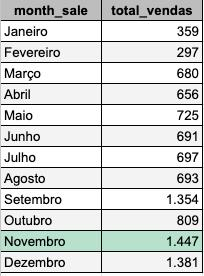

Dessa forma, o mês em que ocorre a maior quantidade de vendas é novembro. Assim, uma sugestão para os gestores da loja online seria melhorar a produtividade da logística para melhor rendimento dos pedidos em sua entrega.

### 3. "Qual é o intervalo médio entre a data de venda e a data de envio?"

Para realizar a análise dos dados para essa pergunta, é necessário utilizar a coluna anteriormente criada **range_days**. Dessa forma, basta selecionar a média de todas as linhas da coluna de intervalo de dias.

Assim, o código em SQL para a consulta é:

In [ ]:
SELECT 
    ROUND(AVG(range_days), 1) AS media_dias --arredonda a média para evitar valores quebrados
FROM 
    `neon-trilogy-461520-m7.SuperstoreSales_dataset.sales_data`

Portanto, o resultado obtido foi que a média do intervalo de dias entre a compra e o envio do produto é de **4 dias**.

Tal informação é importante para a gestão analisar possíveis melhorias e formas de garantir um intervalo menor entre a venda e o envio.

### 4. "Qual produto é mais comprado em cada segmento de clientes?"

Essa pergunta depende das colunas **Segment, Product_Name e Sales** para ser respondida. Inicialmente, é necessário somar a quantidade de vendas e agrupá-las por segmento e nome do produto. Após isso, exibir os resultados de forma decrescente em relação à soma de vendas e em ordem alfabética por segmento. Dito isso, o código fica:

In [ ]:
SELECT 
    SUM(Sales) as Vendas, 
    Product_Name, 
    Segment, 
    RANK() OVER (PARTITION BY Segment ORDER BY SUM(Sales) DESC) as posicao --função no BigQuery para ranquear as somas da venda
FROM 
    `neon-trilogy-461520-m7.SuperstoreSales_dataset.sales_data`
GROUP BY 
    Product_Name, 
    Segment
ORDER BY
    Vendas, Product_Name DESC
QUALIFY posicao = 1 -- selecionando apenas a primeira posição de cada segmento (maior venda)

Assim, foi possível chegar nos seguintes resultados:

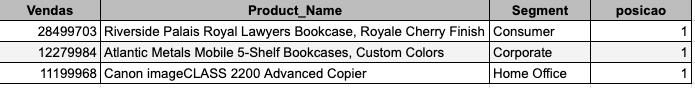

Dessa forma, uma sugestão para o setor de marketing seria encaminhar as campanhas publicitárias desses produtos para os segmentos que mostram uma alta aderência.

## Conclusão

A partir da análise dos dados reais de vendas de uma loja online, foi possível obter insights relevantes sobre o modelo de negócio, os produtos mais vendidos e oportunidades de melhoria nos setores de marketing, logística e estoque. Com base em perguntas orientadas por dados, a exploração e agregação das informações permitiram uma compreensão mais profunda do comportamento de vendas.

Esse tipo de abordagem orientada por dados é essencial para apoiar decisões estratégicas em cenários reais, promovendo maior eficiência e embasamento nas ações adotadas.